In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# paths to your processed JSONL
HDFS_TRAIN = "data/processed/hdfs/train.jsonl"
BGL_TRAIN  = "data/processed/bgl/train.jsonl"

hdfs = pd.read_json(HDFS_TRAIN, lines=True)
bgl  = pd.read_json(BGL_TRAIN,  lines=True)

print("HDFS:", hdfs.shape, hdfs.columns.tolist())
print("BGL :", bgl.shape,  bgl.columns.tolist())

HDFS: (460049, 2) ['text', 'label']
BGL : (3351022, 2) ['text', 'label']


In [2]:
def class_balance(df, name):
    print(f"\n{name} label counts:")
    print(df["label"].value_counts())
    print(f"{name} label %:")
    print(df["label"].value_counts(normalize=True).round(3))
    # class weights useful for training
    counts = df["label"].value_counts()
    weights = {lbl: (len(df) / (len(counts) * c)) for lbl, c in counts.items()}
    print(f"{name} suggested class weights:", weights)
    
class_balance(hdfs, "HDFS")
class_balance(bgl,  "BGL")



HDFS label counts:
label
0    446560
1     13489
Name: count, dtype: int64
HDFS label %:
label
0    0.971
1    0.029
Name: proportion, dtype: float64
HDFS suggested class weights: {0: 0.5151032336080258, 1: 17.052746682482024}

BGL label counts:
label
1    3351022
Name: count, dtype: int64
BGL label %:
label
1    1.0
Name: proportion, dtype: float64
BGL suggested class weights: {1: 1.0}



HDFS length stats (chars): count    460049.000000
mean        919.607346
std         196.212796
min          77.000000
25%         922.000000
50%         922.000000
75%         979.000000
max        9218.000000
Name: text, dtype: float64
HDFS 90th percentile: 1123
HDFS 95th percentile: 1183
HDFS 99th percentile: 1473


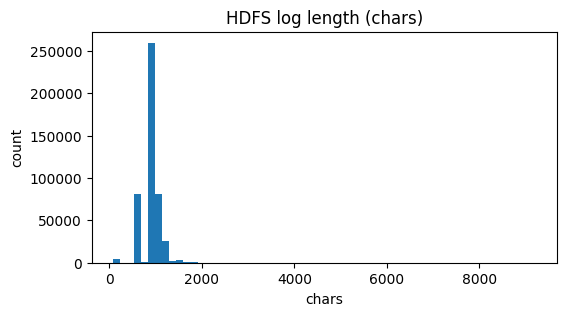


BGL length stats (chars): count    3.351022e+06
mean     3.955718e+01
std      3.942657e+01
min      1.000000e+00
25%      2.100000e+01
50%      2.600000e+01
75%      4.200000e+01
max      6.300000e+02
Name: text, dtype: float64
BGL 90th percentile: 67
BGL 95th percentile: 121
BGL 99th percentile: 171


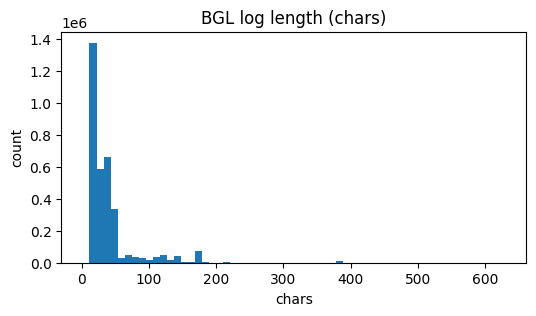

In [3]:
def length_stats(df, name):
    lengths = df["text"].astype(str).str.len()
    print(f"\n{name} length stats (chars):", lengths.describe())
    for p in [90, 95, 99]:
        print(f"{name} {p}th percentile:", int(np.percentile(lengths, p)))
    plt.figure(figsize=(6,3))
    plt.hist(lengths, bins=60)
    plt.title(f"{name} log length (chars)")
    plt.xlabel("chars")
    plt.ylabel("count")
    plt.show()

length_stats(hdfs, "HDFS")
length_stats(bgl,  "BGL")


In [4]:
TOKEN_RE = re.compile(r"[A-Za-z0-9_]+")

def tokenize(s: str):
    return TOKEN_RE.findall(str(s).lower())

def top_tokens(df, n=30):
    tokens = []
    for t in df["text"].astype(str).sample(min(len(df), 5000), random_state=42):
        tokens += tokenize(t)
    return Counter(tokens).most_common(n)

print("HDFS top tokens:", top_tokens(hdfs, n=25))
print("BGL  top tokens:", top_tokens(bgl,  n=25))

HDFS top tokens: [('block', 92722), ('to', 33912), ('namesystem', 32090), ('size', 29755), ('is', 27064), ('added', 27064), ('of', 27017), ('for', 15851), ('src', 15015), ('dest', 15015), ('receiving', 14964), ('addstoredblock', 14940), ('received', 14904), ('blockmap', 14888), ('updated', 14888), ('packetresponder', 14778), ('terminating', 14778), ('from', 14778), ('file', 12237), ('delete', 12231), ('deleting', 12224), ('invalidset', 12176), ('allocateblock', 5000), ('served', 3591), ('exception', 2927)]
BGL  top tokens: [('core', 2091), ('generating', 2017), ('alignment', 683), ('exceptions', 683), ('error', 673), ('iar', 520), ('dear', 520), ('0', 516), ('is', 435), ('interrupt', 411), ('point', 381), ('floating', 360), ('double', 356), ('hummer', 356), ('data', 325), ('ciod', 279), ('program', 277), ('mask', 245), ('at', 217), ('ce', 212), ('sym', 211), ('or', 210), ('instruction', 210), ('file', 209), ('assert', 200)]


In [5]:
def top_tokens_for_label(df, label, n=20):
    sub = df[df["label"]==label]
    if len(sub)==0:
        return []
    toks = []
    for t in sub["text"].astype(str).sample(min(len(sub), 5000), random_state=42):
        toks += tokenize(t)
    return Counter(toks).most_common(n)

print("\nHDFS normal:",  top_tokens_for_label(hdfs, 0)[:20])
print("HDFS anomaly:", top_tokens_for_label(hdfs, 1)[:20])

print("\nBGL normal:",  top_tokens_for_label(bgl, 0)[:20])
print("BGL anomaly:", top_tokens_for_label(bgl, 1)[:20])


HDFS normal: [('block', 93545), ('to', 34459), ('namesystem', 32236), ('size', 30073), ('is', 27235), ('added', 27235), ('of', 27217), ('for', 16032), ('src', 15054), ('dest', 15054), ('addstoredblock', 15047), ('blockmap', 15045), ('updated', 15045), ('received', 15028), ('receiving', 15027), ('from', 15000), ('packetresponder', 15000), ('terminating', 15000), ('file', 12209), ('deleting', 12208)]
HDFS anomaly: [('block', 79958), ('to', 35255), ('namesystem', 26700), ('size', 23024), ('is', 21059), ('added', 21059), ('of', 19939), ('src', 14865), ('dest', 14865), ('receiving', 14001), ('addstoredblock', 13041), ('received', 12287), ('blockmap', 11759), ('updated', 11759), ('for', 11345), ('delete', 10848), ('file', 10741), ('deleting', 10369), ('packetresponder', 9373), ('terminating', 9338)]

BGL normal: []
BGL anomaly: [('core', 2091), ('generating', 2017), ('alignment', 683), ('exceptions', 683), ('error', 673), ('iar', 520), ('dear', 520), ('0', 516), ('is', 435), ('interrupt', 4

In [6]:
def token_log_odds(df):
    # count tokens in each class
    counts = {0: Counter(), 1: Counter()}
    for lbl in [0,1]:
        for t in df.loc[df["label"]==lbl, "text"].astype(str):
            counts[lbl].update(set(tokenize(t)))  # set() to count presence, not frequency

    vocab = set(counts[0]) | set(counts[1])
    # add-1 smoothing
    disc = []
    for w in vocab:
        a = counts[1].get(w,0) + 1
        b = counts[0].get(w,0) + 1
        disc.append((w, np.log(a/b)))
    # positive → more anomaly-ish; negative → more normal-ish
    disc.sort(key=lambda x: x[1], reverse=True)
    return disc

hdfs_disc = token_log_odds(hdfs)
bgl_disc  = token_log_odds(bgl)

print("\nHDFS tokens most associated with ANOMALY:")
print(hdfs_disc[:20])
print("\nHDFS tokens most associated with NORMAL:")
print(hdfs_disc[-20:])

print("\nBGL tokens most associated with ANOMALY:")
print(bgl_disc[:20])
print("\nBGL tokens most associated with NORMAL:")
print(bgl_disc[-20:])



HDFS tokens most associated with ANOMALY:
[('writeblock', np.float64(7.891704659330107)), ('empty', np.float64(5.993961427306569)), ('packet', np.float64(5.993961427306569)), ('redundant', np.float64(5.563242451877201)), ('on', np.float64(4.912089114858159)), ('request', np.float64(4.912089114858159)), ('does', np.float64(4.499809670330265)), ('any', np.float64(4.499809670330265)), ('it', np.float64(4.499809670330265)), ('belong', np.float64(4.499809670330265)), ('but', np.float64(4.496774766635111)), ('receiveblock', np.float64(3.9889840465642745)), ('interrupted', np.float64(3.6888794541139363)), ('changing', np.float64(3.4657359027997265)), ('timed', np.float64(3.4657359027997265)), ('offset', np.float64(3.4657359027997265)), ('meta', np.float64(3.4657359027997265)), ('out', np.float64(3.4657359027997265)), ('pendingreplicationmonitor', np.float64(3.4657359027997265)), ('not', np.float64(3.2686031268901337))]

HDFS tokens most associated with NORMAL:
[('got', np.float64(-3.68925562

In [7]:
from itertools import tee, islice

def bigrams(tokens):
    a, b = tee(tokens)
    next(b, None)
    return zip(a, b)

def top_bigrams(df, n=25):
    big = Counter()
    for t in df["text"].astype(str).sample(min(len(df), 5000), random_state=42):
        toks = tokenize(t)
        big.update(bigrams(toks))
    return big.most_common(n)

print("HDFS top bigrams:", top_bigrams(hdfs, n=20))
print("BGL  top bigrams:", top_bigrams(bgl,  n=20))


HDFS top bigrams: [(('block', 'namesystem'), 32090), (('is', 'added'), 27064), (('added', 'to'), 27064), (('for', 'block'), 15349), (('block', 'src'), 15015), (('src', 'dest'), 15015), (('receiving', 'block'), 14952), (('namesystem', 'addstoredblock'), 14914), (('addstoredblock', 'blockmap'), 14888), (('blockmap', 'updated'), 14888), (('updated', 'is'), 14888), (('to', 'size'), 14888), (('received', 'block'), 14841), (('of', 'size'), 14841), (('packetresponder', 'for'), 14778), (('block', 'terminating'), 14778), (('block', 'of'), 14778), (('size', 'from'), 14778), (('terminating', 'received'), 14567), (('deleting', 'block'), 12224)]
BGL  top bigrams: [(('generating', 'core'), 2017), (('alignment', 'exceptions'), 683), (('double', 'hummer'), 356), (('hummer', 'alignment'), 356), (('floating', 'point'), 346), (('point', 'alignment'), 327), (('ce', 'sym'), 211), (('data', 'tlb'), 187), (('tlb', 'error'), 187), (('error', 'interrupt'), 187), (('ciod', 'error'), 139), (('is', 'not'), 126), 

In [8]:
print("HDFS train labels:", pd.read_json("data/processed/hdfs/train.jsonl", lines=True)["label"].value_counts())
print("HDFS test  labels:", pd.read_json("data/processed/hdfs/test.jsonl",  lines=True)["label"].value_counts())

print("BGL train labels:", pd.read_json("data/processed/bgl/train.jsonl", lines=True)["label"].value_counts())
print("BGL test  labels:", pd.read_json("data/processed/bgl/test.jsonl",  lines=True)["label"].value_counts())


HDFS train labels: label
0    446560
1     13489
Name: count, dtype: int64
HDFS test  labels: label
0    111663
1      3349
Name: count, dtype: int64
BGL train labels: label
1    3351022
Name: count, dtype: int64
BGL test  labels: label
1    837755
Name: count, dtype: int64
